# OilyGiant: oil extraction prediction model

The company has invested in geological exploration, our goal is help them to decide which region (there are a total of three but could be more) will probably have the most profitable operation. Let's start by loading dependencies and defining some constants:

## Dependencies  and constants

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as st

DEBBUG = 1

# file start index, files' names follow an index rule 
F_START = 0
F_END = 2

# NUM_TYPES is a list of valid ordinal types
NUM_TYPES = ('float64', 'int')

#NON_ORDINAL defines column names to be ignored as ordinal values
IGNORE_ORDINAL = ('id', 'phone')

# Path where our analysis are located
GEO_PATH = 'data'

# All files must start with 'geo_data'
FILE_SUB = 'geo_data'

# Random state for replication assurance
RND_ST = 12345

FEATURES = ['f0', 'f1' ,'f2']

FILES = [f'{GEO_PATH}/{FILE_SUB}_{i}.csv' for i in range(F_START, F_END+1)]






## Functions and classes

The following analysis is intendeed to be performed in a undefined amount of geological exploration tables. In order to achieve this goal we will define some particular functions that will be used to summarize and group tasks into commun contexts.

### Functions

In [2]:
### DEPRECATED THIS FUNCTION HAS BEEN DEPRECATED. NEVER USED
def load_dataframe(path):
    """
    This function returns a dataframe loaded from a specific path
    
    Args: 
        path: path where the file is located (ONLY CSV)
    
    Returns:
        dataframe loaded or string error message
        """
    try:
        return pd.read_csv(path)
    except:
        print("Has been an error loading data located in",path)
        
### DEPRECATED, FUNCTION NEVER USED
def get_basic(file, df):
    i = file
    cols = df.columns
    
    info = pd.DataFrame(columns=['duplicates_qty', ]+
                                      [col_i+'_null_qty' for col_i in cols]+
                                      [col_i+'_data_type' for col_i in cols]
                        )

    
    info.loc[i, 'duplicates_qty'] = df.duplicated().sum()

    for col in cols:
        info.loc[i, col+'_null_qty'] = df[col].isnull().sum()
        info.loc[i, col+'_data_type'] = df[col].dtype
        
    return info.to_string()


def get_ordinal_cols(df):
    dtypes = dict(df.dtypes)
    return [col for col, dtype in dtypes.items() if dtype in NUM_TYPES and  dtype not in IGNORE_ORDINAL]



def multi_plot(file, df, plot_type, ord_cols, plt_cols=2):
    ord_cols = get_ordinal_cols(df)
    if len(ord_cols)==0:
        print('No ordinal variables')
        return False

    plt_rows = len(ord_cols)//plt_cols + (0 if len(ord_cols)%plt_cols==0 else 1)
        
    for i, col in enumerate(ord_cols):
        fig = plt.subplot(plt_rows, plt_cols, i+1)
        df[col].plot(kind=plot_type, title=col)

    plt.tight_layout()
    plt.suptitle(file)
    plt.show()
    

def hist(file, df):
     multi_plot(file, df, 'hist', 2)

        
def kde(file, df):
    multi_plot(file, df, 'kde', 2)

        
def box_plot(file, df):
    multi_plot(file, df, 'box', 2)
    
    
if DEBBUG:
    pass
#     print(get_ordinal_cols([*dataframes.values()][0]))
#     box_plot('debbug', [*dfs.values()][0])
    
 



### Classes

In [3]:
class ValData():
    ft = None
    tar = None
    
    def __init__(self, featu, tar):
        self.ft = featu
        self.tar= tar
        
    def summary(self):
        print('Validation set description')
        print('Features:')
        print(self.ft.describe())
        print('\n'*2)
        print('Target:')
        print(self.tar.describe())
    
    def scale(self, scaler, cols):
        self.ft = scaler.transform(self.ft[cols])
        self.ft = pd.DataFrame(self.ft, columns=cols)
        
class TrData():
    ft = None
    tar = None
    scaler = None
   
    def __init__(self, featu, tar):
        self.ft = featu
        self.tar = tar
    
    def scale(self, cols):
        self.scaler = StandardScaler()
        self.scaler = self.scaler.fit(self.ft[cols])
        self.ft = self.scaler.transform(self.ft[cols])
        self.ft = pd.DataFrame(self.ft, columns=cols)
        
    def get_scaler(self):
        return self.scaler
    
    def summary(self):
        print('Training set description')
        print('Features:')
        print(self.ft.describe())
        print('\n'*2)
        print('Target:')
        print(self.tar.describe())
    
        
class TVData():
    val = None
    tr = None
    scaler = None
    
    def __init__(self):
        self.val = None
        self.tr = None
    
    def split(self, featu, tar, size=0.25):
        tr_ft, vl_ft, tr_tar, vl_tar = train_test_split(featu, tar, test_size=size, random_state = RND_ST)
        self.set_tr_vl(tr_ft, vl_ft, tr_tar, vl_tar)

    def set_tr_vl(self, tr_ft, vl_ft, tr_tar, vl_tar):
        self.val = ValData(vl_ft, vl_tar)
        self.tr = TrData(tr_ft, tr_tar)
        
    def scale(self, cols):
        self.tr.scale(cols)
        scaler = self.tr.get_scaler()
        self.val.scale(scaler, cols)

        
    
    def get_summary(self):
        self.val.summary()
        print('\n'*2,'***'*10, '\n'*2)
        self.tr.summary()
        
        
class DevLeCrossValidation():
    current_tv = None
    cross_v_score = []
    
    model = None
    featu = None
    tar = None
    scaled = False

    def __init__(self, model, featu, tar, scaled:bool):
        self.model = model
        self.featu = featu
        self.tar = tar
        self.scaled = scaled

    # v is a boolean parameter that means verbose, when True it prints the process
    def perform(self,  n=5, v=False):
        sample_size = int(len(self.featu)/ n)
        
        for i in range(0, len(self.featu)-1, sample_size):
            
            vl_ft = self.featu.iloc[i:i+sample_size]
            vl_tar = self.tar[vl_ft.index]
            
            tr_ft = self.featu.query('index not in @vl_ft.index')
            tr_tar = self.tar[tr_ft.index]

        
            self.current_tv = TVData()
            self.current_tv.set_tr_vl(tr_ft, vl_ft, tr_tar, vl_tar)
            cols = get_ordinal_cols(self.current_tv.tr.ft)

            if self.scaled == True:
                self.current_tv.scale(cols)
            
            if v:
                print(self.current_tv.get_summary())
            
            self.__train(cols)
            self.__score()
        
           
    def __score(self):
        pred = self.model.predict(self.current_tv.val.ft)
        result = self.current_tv.val.tar
        self.cross_v_score.append( mean_squared_error(result, pred))
        
    def __train(self, cols):
        self.model.fit(pd.DataFrame(self.current_tv.tr.ft, columns=cols), self.current_tv.tr.tar)
    
    def get_score(self, ):
        if len(self.cross_v_score)==0:
            self.perform()
        return sum(self.cross_v_score)/len(self.cross_v_score)
    
   
    def set_data(self, featu, tar):
        self.data = TVData()
        self.data.split(featu, tar)
    
    
class BlackBoxModel():
    model = None
    data = None
    score = None
    predicted = None

    def __init__(self, model):
        self.model = model

    def load_data(self, featu, tar):
        self.data  = TVData()
        self.data.split(featu, tar)

    def scale_data(self):
        self.data.scale(get_ordinal_cols(self.data.tr.ft))

    def predict(self, featu = None):
        if type(featu)!= type(None):
            self.predicted = self.model.predict(featu)
        else:
            self.predicted = self.model.predict(self.data.val.ft)
        return self.predicted

    def get_trained_model(self):
        return self.model

    def fit(self):
        self.model.fit(self.data.tr.ft, self.data.tr.tar)

    def r2_score(self):
        return r2_score(self.data.val.tar, self.model.predict(self.data.val.ft))
    
    def mse_score(self):
        return mean_squared_error(self.data.val.tar, self.model.predict(self.data.val.ft))


class FinancialEstimatior():
    costs = 100_000_000
    extr_pts = 200
    product_units = 1000
    benefit = 4.5
    
    geo_data = None
    
    
    def revenue(self, geo_data):
        self.geo_data = geo_data
        
        top_200 = self.geo_data.sort_values(by='product_predicted', ascending=False)[0:self.extr_pts].index
        
        self.geo_data = self.geo_data.iloc[top_200].copy()
        
        self.geo_data['revenue'] = self.geo_data['product']*self.product_units*self.benefit
        self.geo_data['predicted_revenue'] = self.geo_data['product_predicted']*self.product_units*self.benefit

        return [self.geo_data, self.geo_data['revenue'].sum()-self.costs] 
    
    
    def bootstrap_revenue(self, geo_data, indexes):
        self.geo_data = geo_data
        
        top_200 = self.geo_data.iloc[indexes].sort_values(by='product_predicted', ascending=False)[0:self.extr_pts].index
        
        self.geo_data = self.geo_data.iloc[top_200].copy()
        
        self.geo_data['revenue'] = self.geo_data['product']*self.product_units*self.benefit
        self.geo_data['predicted_revenue'] = self.geo_data['product_predicted']*self.product_units*self.benefit

        return [self.geo_data, self.geo_data['revenue'].sum()-self.costs] 


## Loading data: 

In [4]:
dfs = dict()
for path in FILES:
    try:
        file =  pd.read_csv(path)
    except:
        print("Has been an error loading data located in",path)
        
    dfs.update({path:file})


## Exploratory data analysis:

Let's check column data types and dulicates so we can address them in case they exist.

In [5]:
for name, df in dfs.items():
    i = file
    cols = df.columns
    
    info = pd.DataFrame(columns=['duplicates_qty', ]+
                                      [col_i+'_null_qty' for col_i in cols]+
                                      [col_i+'_data_type' for col_i in cols]
                        )
    print(name)
    
    info.loc[name, 'duplicates_qty'] = df.duplicated().sum()

    for col in cols:
        info.loc[name, col+'_null_qty'] = df[col].isnull().sum()
        info.loc[name, col+'_data_type'] = df[col].dtype
        
    print(info.to_string())
    

/datasets/geo_data_0.csv
                         duplicates_qty id_null_qty f0_null_qty f1_null_qty f2_null_qty product_null_qty id_data_type f0_data_type f1_data_type f2_data_type product_data_type
/datasets/geo_data_0.csv              0           0           0           0           0                0       object      float64      float64      float64           float64
/datasets/geo_data_1.csv
                         duplicates_qty id_null_qty f0_null_qty f1_null_qty f2_null_qty product_null_qty id_data_type f0_data_type f1_data_type f2_data_type product_data_type
/datasets/geo_data_1.csv              0           0           0           0           0                0       object      float64      float64      float64           float64
/datasets/geo_data_2.csv
                         duplicates_qty id_null_qty f0_null_qty f1_null_qty f2_null_qty product_null_qty id_data_type f0_data_type f1_data_type f2_data_type product_data_type
/datasets/geo_data_2.csv              0           

__Based in the gathered data we have not found duplicated data and the column data types are valid for our porpuses. Our data do not require further preprocessing steps__

### Histograms, KDE and boxplots

As we already know plots are one of the best way to summarize data, let's check the histograms for each region

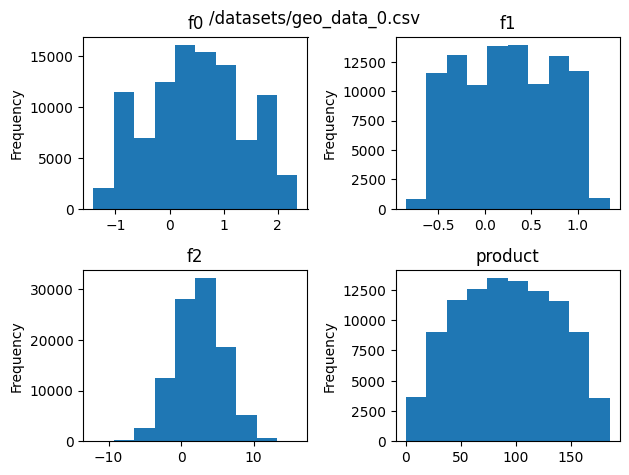

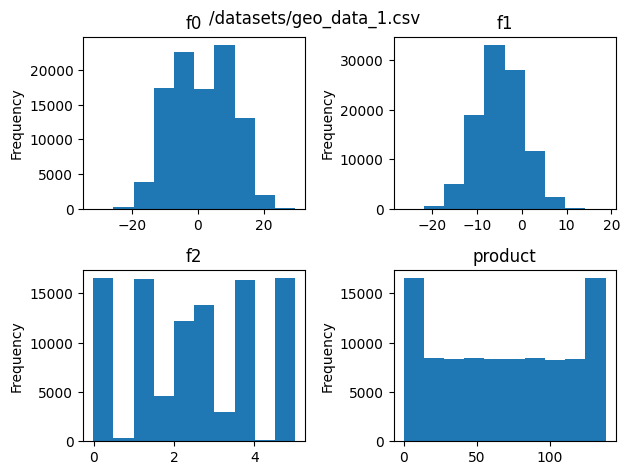

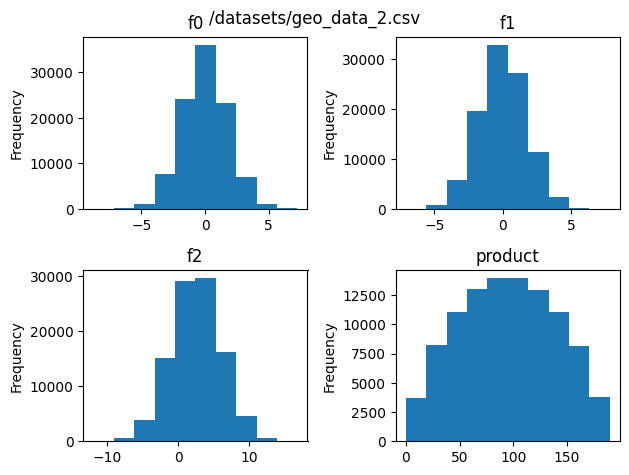

In [6]:
for name, df in dfs.items():
    hist(name, df)

__Based in the gathered data we can conclude:__
- Region 0: 
    - f0: Values mostly ranging from -1 to 2.
    - f1: Values mostly ranging from -0.5 to 1. 
    - f2: Values mostly ranging from -10 to 10. 
    - product: Values mostly ranging from 0 to 150 in a normal distribution 
- Region 1: 
    - f0: Values mostly ranging from -20 to 20. Significative difference comparing to range of values for f0 in region 0
    - f1: Values mostly ranging from -20 to 10. Significative difference comparing to range of values for f1 in region 0
    - f2: Values mostly ranging from 2 to 5. Significative difference comparing to range of values for f2 in region 0. We can also find 4 intervals with high relative frequency 
    - product: Values mostly ranging from 0 to 150 with a significant amount of areas with 0 product
- Region 2:
    - f0: Values mostly ranging from -5 to 5.
    - f1: Values mostly ranging from -5 to 5.
    - f2: Values mostly ranging from -10 to 10.
    - product: Normal distribution ranging mostly from 0 to 160

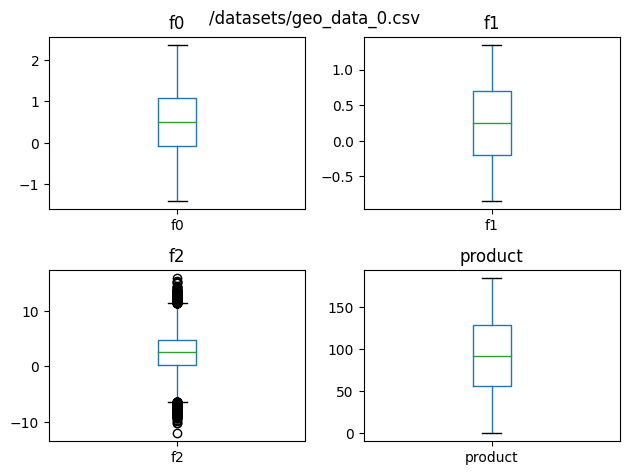

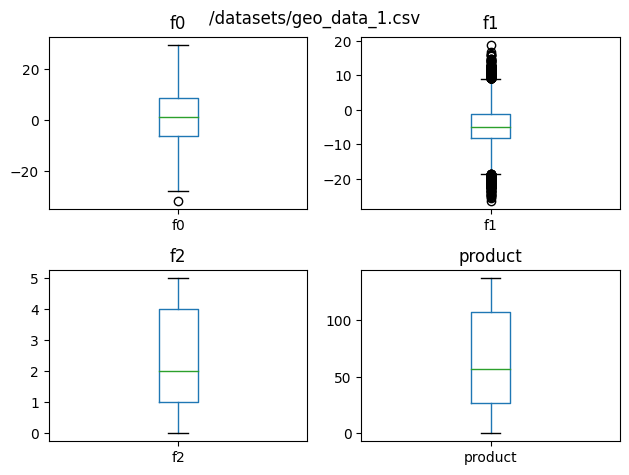

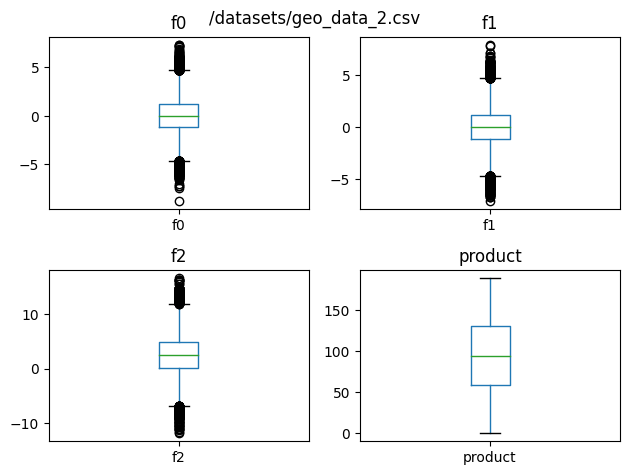

In [7]:
for name, df in dfs.items():
    box_plot(name, df)

__Based in the gathered data we can conclude from the boxplots:__
- Region 0: 
    - f0: There is not outliers based in the 1.5*IQR 
    - f1: There is not outliers based in the 1.5*IQR 
    - f2: There is outliers based in the 1.5*IQR. Outliers have been found at both the upper and lower extremes. The data is slightly skewed to the right
    - product: There is not outliers based in the 1.5*IQR, The data is slightly skewed to the right
- Region 1: 
    - f0: There is not outliers based in the 1.5*IQR 
    - f1: There is outliers based in the 1.5*IQR. Outliers have been found at both the upper and lower extremes.
    - f2: There is not outliers based in the 1.5*IQR 
    - product: There is not outliers based in the 1.5*IQR, The data is slightly skewed to the right
- Region 2:
    - f0: There is outliers based in the 1.5*IQR. Outliers have been found at both the upper and lower extremes.
    - f1: There is outliers based in the 1.5*IQR. Outliers have been found at both the upper and lower extremes.
    - f2: There is outliers based in the 1.5*IQR. Outliers have been found at both the upper and lower extremes.
    - product: There is not outliers based in the 1.5*IQR.

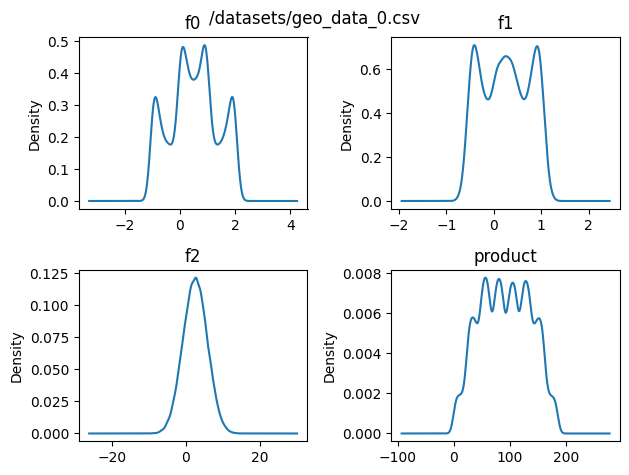

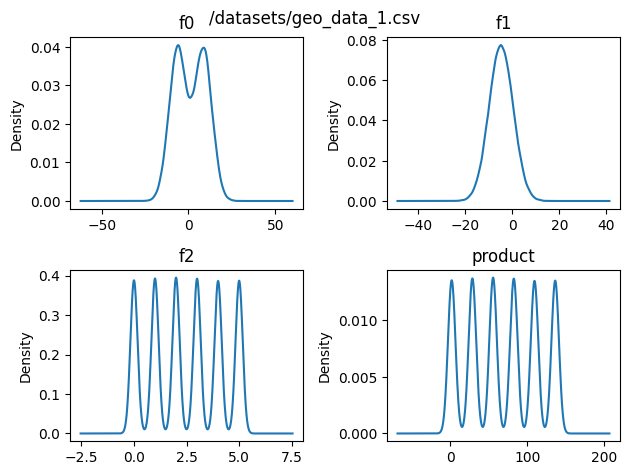

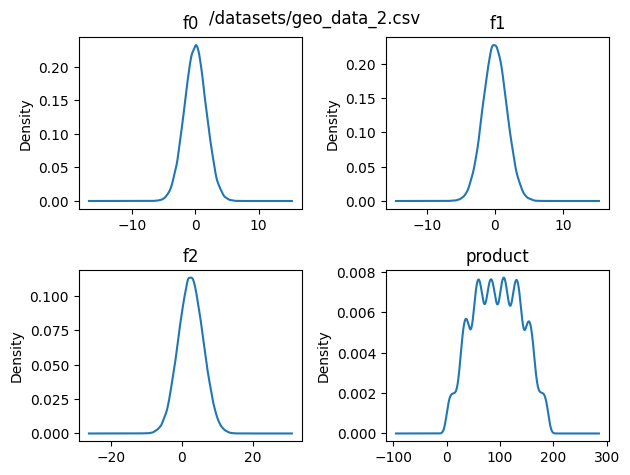

In [8]:
for name, df in dfs.items():
    kde(name, df)

__Based in the gathered data we can conclude from the KDE plots:__

- Region 0: 
    - KDE plot suggests the data has been generated rather than be real data. The peaks shows the maximun concentration of values.
- Region 1: 
    - KDE plot suggests the data has been generated rather than be real data. The peaks shows the maximun concentration of values. Our target (product) has the lower maximun (less than 200) and has the most presence of density peaks.
- Region 2:
    - KDE plot suggests the data has been generated rather than be real data. The peaks shows the maximun concentration of values.

## Model implementation

### Cross Validation score for Linear Regression Model

We will evaluate the model performance using cross validation, the impllementation has been encapsulated in a class called DevLeCrossValidation. When declaring the instance the following attributes are provided: Instance of model that will be used to make predictions, features, target and finally an optional parameter espicify if the validation has to be done with scaled data. 
To perform the analysis we use the `perform()` method in which we specify the number of sets to perform the validation. We can retrieve the mean of scores using the `get_score()` method

In [9]:
cv_scores = {}
for file, df in dfs.items():
    model = LinearRegression()
    tar = df['product']
    featu = df[FEATURES]
 
    cv = DevLeCrossValidation(model, featu, tar, scaled=True)
    cv.perform(5)
    cv_scores.update({file:cv.get_score()})
    
print(cv_scores)


{'/datasets/geo_data_0.csv': 1420.879787846689, '/datasets/geo_data_1.csv': 710.8363167873272, '/datasets/geo_data_2.csv': 1008.7507783076921}


__As we can see, using the Linear Regression Model the region with best performance is Region 2.__

### Making predictions


Let's add the predicted values to our original dataframes. In this case we will encapsulate the process inside the BlackBoxModel() which encapsulates some methods that will be the process modular.

In [10]:
dfs_pred = {}

for file, df in dfs.items():
    model = BlackBoxModel(LinearRegression())
    model.load_data(df[FEATURES], df['product'])
    model.scale_data()
    model.fit()
    print(f'r2 score for {file}:',model.r2_score())
    print(f'mse score for {file}', model.mse_score())
    print('\n')
    df['product_predicted'] = model.predict(df[FEATURES])
    

    dfs_pred.update({file:df})

r2 score for /datasets/geo_data_0.csv: 0.27994321524487786
mse score for /datasets/geo_data_0.csv 1412.2129364399243


r2 score for /datasets/geo_data_1.csv: 0.9996233978805127
mse score for /datasets/geo_data_1.csv 0.7976263360391157


r2 score for /datasets/geo_data_2.csv: 0.20524758386040443
mse score for /datasets/geo_data_2.csv 1602.3775813236196




__The Linear Regression Model works the best when is trained with data coming from region 2__
Now, let's check  how well the predictions where made

AxesSubplot(0.125,0.11;0.775x0.77)


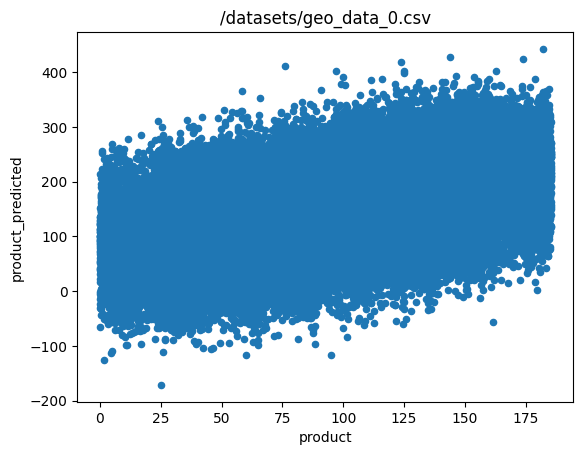

AxesSubplot(0.125,0.11;0.775x0.77)


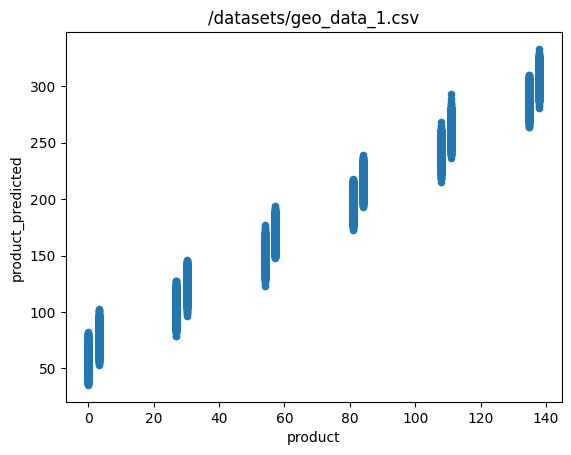

AxesSubplot(0.125,0.11;0.775x0.77)


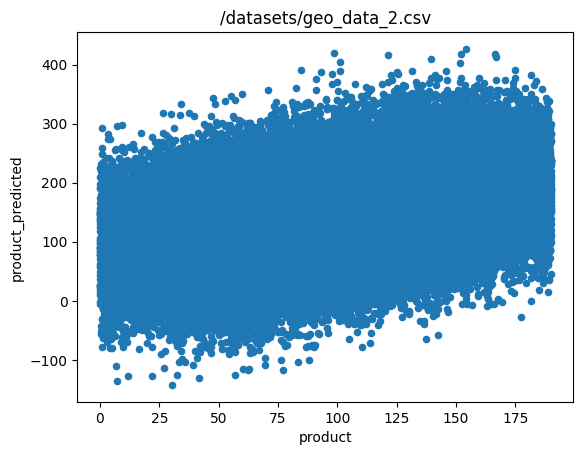

In [11]:
for file, df in dfs_pred.items():
    print(df[['product', 'product_predicted']].plot(kind='scatter', x='product', y='product_predicted'))
    plt.title(file)
    plt.show()

__In both region 0 and 2 there are product predictions ranging from negative values. The predictions in region 1 are bassed in the previous values used in training and as we saw in the histogram there are a limited values that product can take, this means our model only predicts known values__

__Based on the information provided in the case description we know that:__
Dada la inversión de 100 millones por 200 pozos petrolíferos, de media un pozo petrolífero debe producir al menos un valor de 500,000 dólares en unidades para evitar pérdidas (esto es equivalente a 111.1 unidades). Compara esta cantidad con la cantidad media de reservas en cada región.

__We need to check the mean of product in each region, if it meets the condition the exploration could potentially be profitable__

Basic calculation of the mean product

In [12]:
for file, df in dfs_pred.items():
    print(f'Mean of Predicted oil reserves in {file}:', df['product'].mean())

Mean of Predicted oil reserves in /datasets/geo_data_0.csv: 92.50000000000001
Mean of Predicted oil reserves in /datasets/geo_data_1.csv: 68.82500000000002
Mean of Predicted oil reserves in /datasets/geo_data_2.csv: 95.00000000000004


__It could appear the mean of product does not meet the minimun needed in any region, but we are still including some records of very bad zones instead of the mean of the 200 best zones. Let´s do that in the next section__


Now let's check the net profit for each region

In [13]:
top_region = None
dfs_reve = {}
best_net_profit = 0
top_reg_file = ''

for file, df in dfs_pred.items():
    financial = FinancialEstimatior()
    df_rev, net_profit = financial.revenue(df)
    dfs_reve.update({file:df_rev})
    print(f'{file} net profit {net_profit}')
    if  net_profit>best_net_profit:
        best_net_profit = net_profit
        top_region = df_rev
        top_reg_file = file
else:
    print('THE BEST REGION IS: ', top_reg_file)


/datasets/geo_data_0.csv net profit 29489604.11773096
/datasets/geo_data_1.csv net profit 24150866.966815084
/datasets/geo_data_2.csv net profit 25555785.775059536
THE BEST REGION IS:  /datasets/geo_data_0.csv


In [14]:
for file, df in dfs_reve.items():
    print(file ,df.loc[:,['product']].mean())

/datasets/geo_data_0.csv product    143.877338
dtype: float64
/datasets/geo_data_1.csv product    137.945408
dtype: float64
/datasets/geo_data_2.csv product    139.506429
dtype: float64


__Now all the regions meet the condition to make the project profitable__

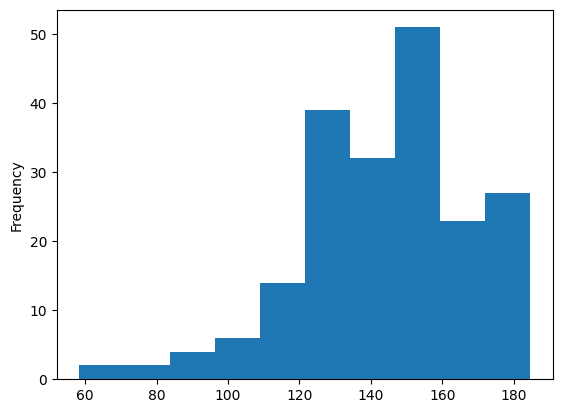

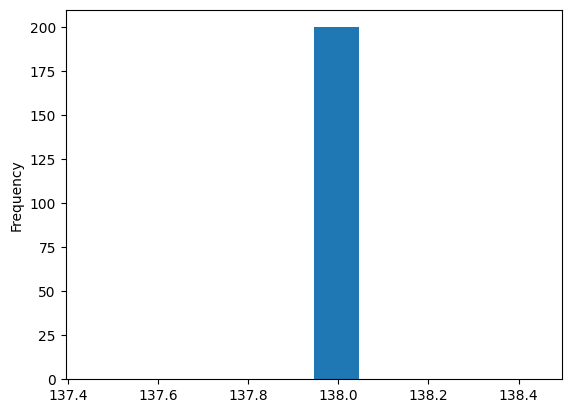

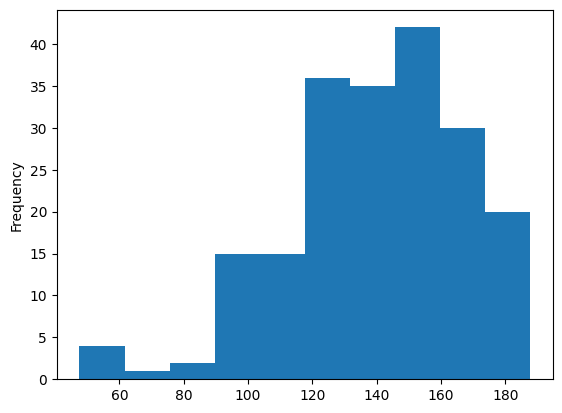

In [15]:
for file, df in dfs_reve.items():
    df['product'].plot(kind='hist')
    plt.show()

__The histogram for each region is skewed to the right indicating the best zones have been choosen__

In [16]:
state = RandomState(12345)


for name, df in dfs_pred.items():
    bootstraped_revenues = []
    bankrupt_count = 0
    region = df
    print(f'analisis for {name}')
    for i in range(1000):
        financial = FinancialEstimatior()
        # If the sample grows bigger the probability of bankrupcy decreases
        smpl_index = region['product'].sample(n=10000, random_state=state, replace=True).index
        rev_df, net_profit = financial.bootstrap_revenue(region, smpl_index)
        bootstraped_revenues.append(net_profit)
        if net_profit<0:
            bankrupt_count += 1
    else:
        if bankrupt_count != 0:
            print(f'Bankrupt based on bootstraped data:', bankrupt_count/1000)
        else:
            print(f'No bankrupt scenario found')

    revs = pd.Series(bootstraped_revenues)
    print('CONFIDENCE INTERVAL',revs.quantile(0.05),revs.quantile(0.95))


# results = st.ttest_1samp(revs, top_region['revenue'].sum())
# print(results.pvalue)

analisis for /datasets/geo_data_0.csv
No bankrupt scenario found
CONFIDENCE INTERVAL 22039565.46171689 27701760.857504986
analisis for /datasets/geo_data_1.csv
No bankrupt scenario found
CONFIDENCE INTERVAL 24150866.966815084 24150866.966815084
analisis for /datasets/geo_data_2.csv
No bankrupt scenario found
CONFIDENCE INTERVAL 19713586.80142819 25862940.837177813


__Based in the gathered data we discard region 0 as the best option, the confidence interval does not include the predicted revenue. In the other hand even when region 2 does not have the biggest predicted revenue it falls into the confidence interval making profitable any exploration in that region.__